# reading tensorboard files for compiling the results

In [1]:
import os
from tensorboard.backend.event_processing import event_accumulator
import numpy as np
import matplotlib.pyplot as plt

from utils import FEATURES_DIR

plt.style.use('seaborn-v0_8-deep')
from glob import glob
from glob import escape as gescape
from scipy.stats import sem
import pickle

In [2]:
# results_root_dir = os.path.expanduser('~/data/multimodal_decoding/glm/regression_results_mni_mmda4_train')
# results_root_dir = os.path.expanduser('~/data/multimodal_decoding/glm/regression_results_mni_mmda_val_set_train')
results_root_dir = os.path.expanduser('~/data/multimodal_decoding/glm/regression_results_mni_mmda_cv_shuffle_train')

model_names = [
    'RESNET152_AVGPOOL',
   #  'VITL16_ENCODER',
   #  'CLIP_V',
   # 'BERT_LARGE',
   #  'GPT2XL_AVG',
   # 'CLIP_L',
    # 'RESNET152_AVGPOOL_PCA768',
     # 'GPT2XL_AVG_PCA768',
     # 'VITL16_ENCODER_PCA768',
    # 'CLIP_L_PCA768',
    # 'CLIP_V_PCA768'
]

subjects = ['sub-01', 'sub-02', 'sub-04', 'sub-05', 'sub-07']
# subjects = ['sub-01', 'sub-02']

In [3]:
class HyperParameters():
    def __init__(self, optimizer='SGD', lr=0.01, wd=0.01, dropout=False, loss='MSE', full_train=False) -> None:
        self.optimizer = optimizer
        self.lr = lr
        self.wd = wd
        self.dropout = dropout
        self.loss = loss
        self.full_train = full_train
    
    def get_hp_string(self):
        descr = f"[optim:{self.optimizer}][lr:{str(self.lr).replace('.','-')}][wd:{str(self.wd).replace('.','-')}][drop:{self.dropout}][loss:{self.loss}]"
        if self.full_train:
            descr += "_full_train"
        return descr

    def __iter__(self):
        yield self.optimizer
        yield self.lr
        yield self.wd
        yield self.dropout
        yield self.loss

In [4]:
MAXEPOCH = 400

test_loss_key = 'Testing/MSE loss'

MODE_PYTORCH = "PYTORCH"
MODE_SKLEARN = "SKLEARN"
SKLEARN_ALPHAS = [1, 10, 100]

MODE = MODE_PYTORCH

if MODE == MODE_PYTORCH:
    HPs = [
        # HyperParameters(optimizer='SGD', lr=0.01, wd=0.00, dropout=False, loss='MSE'),
        # HyperParameters(optimizer='SGD', lr=0.01, wd=0.01, dropout=False, loss='MSE'),
        # HyperParameters(optimizer='SGD', lr=0.01, wd=0.01, dropout=False, loss='MSE', full_train=True),
        HyperParameters(optimizer='ADAM', lr=0.00001, wd=0.00, dropout=False, loss='MSE'),


        
        # HyperParameters(optimizer='ADAM', lr=0.0001, wd=0.00, dropout=False, loss='MSE'),
        # HyperParameters(optimizer='ADAM', lr=0.001, wd=0.00, dropout=False, loss='MSE'),
        # HyperParameters(optimizer='ADAM', lr=0.01, wd=0.00, dropout=False, loss='MSE'),

        # # HyperParameters(optimizer='ADAM', lr=0.001, wd=0.01, dropout=False, loss='MSE'),
        # # HyperParameters(optimizer='ADAM', lr=0.010, wd=0.01, dropout=False, loss='MSE'),
        # # HyperParameters(optimizer='ADAM', lr=0.1, wd=0.01, dropout=False, loss='MSE'),

        # HyperParameters(optimizer='ADAM', lr=0.0001, wd=0.1, dropout=False, loss='MSE'),
        # HyperParameters(optimizer='ADAM', lr=0.001, wd=0.1, dropout=False, loss='MSE'),
        # HyperParameters(optimizer='ADAM', lr=0.01, wd=0.1, dropout=False, loss='MSE'),

        # HyperParameters(optimizer='ADAM', lr=0.0001, wd=1, dropout=False, loss='MSE'),
        # HyperParameters(optimizer='ADAM', lr=0.001, wd=1, dropout=False, loss='MSE'),
        # HyperParameters(optimizer='ADAM', lr=0.01, wd=1, dropout=False, loss='MSE'),

        # HyperParameters(optimizer='ADAM', lr=0.0001, wd=1, dropout=False, loss='MSE', full_train=True),


        # HyperParameters(optimizer='ADAM', lr=0.01, wd=0.01, dropout=False, loss='MSE', full_train=True),
        # HyperParameters(optimizer='ADAM', lr=0.01, wd=0.0, dropout=False, loss='MSE', full_train=True),
        # HyperParameters(optimizer='ADAM', lr=0.01, wd=0.01, dropout=False, loss='MSE', full_train=True),
    ]
else:
    HPs = [HyperParameters(wd=alpha) for alpha in SKLEARN_ALPHAS]

HPs

In [6]:
loss_results = {}
distance_matrices = {}


for subject in subjects:
    distance_matrices[subject] = {}
    loss_results[subject] = {}
    for model_name in model_names:
        distance_matrices[subject][model_name] = {}
        loss_results[subject][model_name] = {}
        if MODE == MODE_PYTORCH:
            for hp in HPs:
                hp_str = hp.get_hp_string() + 'fold_0'
                distance_matrix_file = os.path.join(results_root_dir, subject, model_name, 'distance_matrix', hp_str, 'distance_matrix.p')
                loss_results_file = os.path.join(results_root_dir, subject, model_name, 'loss_results', hp_str, 'loss_results.p')
                
                if os.path.isfile(distance_matrix_file): 
                    print(distance_matrix_file)
                    distance_matrices[subject][model_name][hp] = pickle.load(open(distance_matrix_file, 'rb'))
                else:
                    distance_matrices[subject][model_name][hp] = None
                if os.path.isfile(loss_results_file):
                    print(loss_results_file)

                    loss_results[subject][model_name][hp] = pickle.load(open(loss_results_file, 'rb'))
                else:
                    loss_results[subject][model_name][hp] = None
        else:
            for alpha, hp in zip(SKLEARN_ALPHAS, HPs):
                hp_str = f'alpha_{alpha}'
                distance_matrix_file = os.path.join(results_root_dir, subject, model_name, 'distance_matrix', f'sklearn_alpha_{alpha}', 'distance_matrix.p')
                print(distance_matrix_file)
                if os.path.isfile(distance_matrix_file):
                    distance_matrices[subject][model_name][hp] = pickle.load(open(distance_matrix_file, 'rb'))
                else:
                    distance_matrices[subject][model_name][hp] = None


/home/mitja/data/multimodal_decoding/glm/regression_results_mni_mmda_cv_shuffle_train/sub-01/RESNET152_AVGPOOL/distance_matrix/[optim:ADAM][lr:1e-05][wd:0-0][drop:False][loss:MSE]fold_0/distance_matrix.p
/home/mitja/data/multimodal_decoding/glm/regression_results_mni_mmda_cv_shuffle_train/sub-01/RESNET152_AVGPOOL/loss_results/[optim:ADAM][lr:1e-05][wd:0-0][drop:False][loss:MSE]fold_0/loss_results.p


## best decoding accuracy for each HP across training epochs
- find the best epoch based on the testing MSE loss
- obtain the distance matrix corresponding to that epoch
- calculate accuracy

In [10]:
def pairwise_accuracy(dist_mat):
    # dist_mat      # d(i,j) -> distance of the prediction of i to the original of j
    # first 70 -> captions
    # second 70 -> images
    # since the AI model is the same, original of caption is the same as the original of the image
    
    diag     = dist_mat.diagonal()[:, np.newaxis]               # all congruent distances
    comp_mat = diag < dist_mat                                  # we are interested in i,j where d(i,i) < d(i,j)
    corrects = comp_mat.sum()                                   # counting the trues (everything is counted two times because of the same ground-truth)
    
    n = diag.shape[0]
    score_agnostic = corrects / (n*n-(2*n))                     # -2*n is there to remove the diagonal two times (as it is repeated two times)

    ######
    dist_captions = dist_mat[:70, :70]
    diag     = dist_captions.diagonal()[:, np.newaxis]               
    comp_mat = diag < dist_captions                                  
    corrects = comp_mat.sum()
    
    n = diag.shape[0]
    score_captions = corrects / (n*n-n)
    ######
    dist_images   = dist_mat[70:, 70:]
    diag     = dist_images.diagonal()[:, np.newaxis]               
    comp_mat = diag < dist_images                                  
    corrects = comp_mat.sum()
    
    n = diag.shape[0]
    score_images = corrects / (n*n-n)

    return score_agnostic, score_captions, score_images

def pairwise_accuracy_duo_(dist_mat, classes):
    diag     = dist_mat.diagonal()                              # all congruent distances

    n = diag.shape[0]
    corrects = 0
    count = 0
    for i in range(n):
        for j in range(i+1, n):
            if classes[i] != classes[j]:
                if (dist_mat[i,i] + dist_mat[j,j]) < (dist_mat[i,j] + dist_mat[j,i]):
                    corrects += 1
                count += 1
    
    score = corrects / count
    return score

def pairwise_accuracy_duo(dist_mat, classes):
    # dist_mat      # d(i,j) -> distance of the prediction of i to the original of j
    # first 70 -> captions
    # second 70 -> images
    # since the AI model is the same, original of caption is the same as the original of the image
    
    score_agnostic = pairwise_accuracy_duo_(dist_mat, classes)
    score_captions = pairwise_accuracy_duo_(dist_mat[:70, :70], classes[:70])
    score_images   = pairwise_accuracy_duo_(dist_mat[70:, 70:], classes[70:])
    
    return score_agnostic, score_captions, score_images

In [11]:
distance_metric  = ['cosine', 'euclidean'][0]
decoding_modes   = ['modality-agnostic', 'captions', 'images']

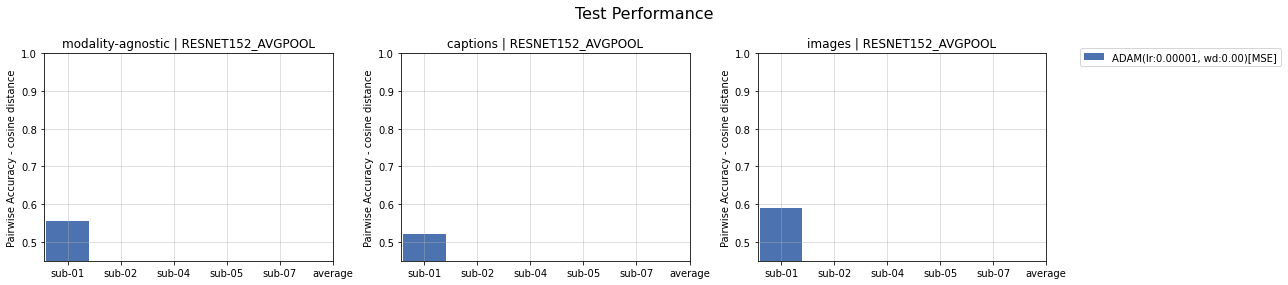

In [12]:
fig, axes = plt.subplots(len(model_names), len(decoding_modes), figsize=(len(decoding_modes)*6, len(model_names)*4), squeeze=False)
xticklabels = subjects[:] + ['average']
xticks = np.arange(len(xticklabels))

for row, model_name in enumerate(model_names):
    # for col, decoding_mode in enumerate(decoding_modes):
    bar_width = 0.8/len(HPs)
    first_bar_offset = -0.4 + (bar_width/2)
    bar_offsets = [first_bar_offset + (i*bar_width) for i in range(len(HPs))]
    for hpidx, hp in enumerate(HPs):
        subjects_accuracies = {'modality-agnostic':[], 'captions':[], 'images':[]}
        for subjectidx, subject in enumerate(subjects):
            if distance_matrices[subject][model_name][hp] is not None:
                accuracies = pairwise_accuracy(distance_matrices[subject][model_name][hp][distance_metric])
                subjects_accuracies['modality-agnostic'].append(accuracies[0])
                subjects_accuracies['captions'].append(accuracies[1])
                subjects_accuracies['images'].append(accuracies[2])
            else:
               
                subjects_accuracies['modality-agnostic'].append(np.nan)
                subjects_accuracies['captions'].append(np.nan)
                subjects_accuracies['images'].append(np.nan)
                
        for col, decoding_mode in enumerate(decoding_modes):
            subjects_accuracies_temp = np.array(subjects_accuracies[decoding_mode])
            subjects_mean = subjects_accuracies_temp.mean()
            subjects_sem  = [0] * len(xticklabels)
            subjects_sem[-1] = sem(subjects_accuracies_temp)
            subjects_accuracies[decoding_mode].append(subjects_mean)
            axes[row,col].bar(xticks+bar_offsets[hpidx], subjects_accuracies[decoding_mode], bar_width, yerr=subjects_sem, label=f"{hp.optimizer}(lr:{hp.lr:0.5f}, wd:{hp.wd:0.2f})[{hp.loss}]{'_full_train' if hp.full_train else ''}")
            # axes[row,col].bar(xticks[-1]+bar_offsets[hpidx], subjects_accuracies[-1], yerr=subjects_sem, width=bar_width)
            axes[row,col].set_xticks(xticks)
            axes[row,col].set_xticklabels(xticklabels)
            axes[row,col].grid(alpha=0.5)
            axes[row,col].set_title(f'{decoding_mode} | {model_name}')
            axes[row,col].set_ylabel(f'Pairwise Accuracy - {distance_metric} distance')
            axes[row,col].set_ylim(bottom=0.45, top=1.0)
            # axes[row,col].axhline(y=0.5, color='r', linestyle='-')
            if row == 0 and col == len(decoding_modes) - 1:
                axes[row,col].legend(bbox_to_anchor=(1.1, 1.05))#loc="lower right")
fig.suptitle("Test Performance", fontsize=16)
plt.tight_layout()
plt.savefig("test_performance.png", dpi=300)

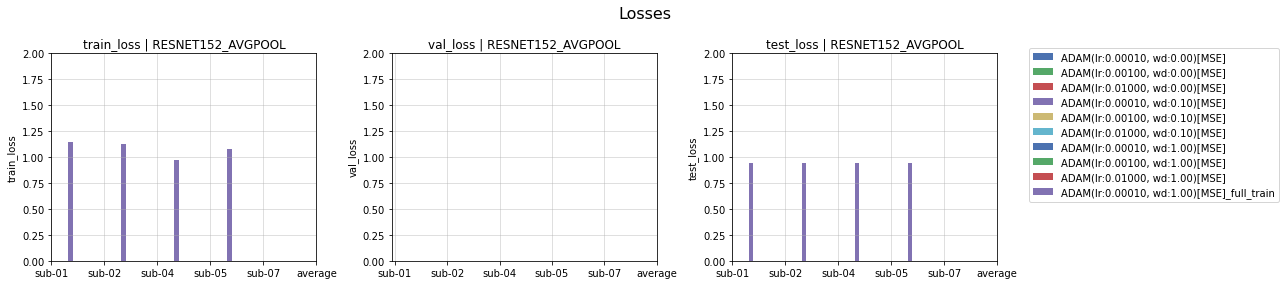

In [24]:
loss_names = ["train_loss", "val_loss", "test_loss"]
fig, axes = plt.subplots(len(model_names), len(loss_names), figsize=(len(loss_names)*6, len(model_names)*4), squeeze=False)
xticklabels = subjects[:] + ['average']
xticks = np.arange(len(xticklabels))
for row, model_name in enumerate(model_names):
    # for col, decoding_mode in enumerate(decoding_modes):
    bar_width = 0.8/len(HPs)
    first_bar_offset = -0.4 + (bar_width/2)
    bar_offsets = [first_bar_offset + (i*bar_width) for i in range(len(HPs))]
    for hpidx, hp in enumerate(HPs):
        subjects_losses = {name: [] for name in loss_names}
        for subjectidx, subject in enumerate(subjects):
            if loss_results[subject][model_name][hp] is not None:
                losses = loss_results[subject][model_name][hp]
                for name in loss_names:
                    if name in losses.keys():
                        subjects_losses[name].append(losses[name])
                    else:
                        subjects_losses[name].append(np.nan)
                    
            else:
                for name in loss_names:
                    subjects_losses[name].append(np.nan)
        for col, loss_name in enumerate(loss_names):
            subjects_losses_temp = np.array(subjects_losses[loss_name])
            subjects_mean = subjects_losses_temp.mean()
            subjects_sem  = [0] * len(xticklabels)
            subjects_sem[-1] = sem(subjects_losses_temp)
            subjects_losses[loss_name].append(subjects_mean)
            axes[row,col].bar(xticks+bar_offsets[hpidx], subjects_losses[loss_name], bar_width, yerr=subjects_sem, label=f"{hp.optimizer}(lr:{hp.lr:0.5f}, wd:{hp.wd:0.2f})[{hp.loss}]{'_full_train' if hp.full_train else ''}")
            # axes[row,col].bar(xticks[-1]+bar_offsets[hpidx], subjects_accuracies[-1], yerr=subjects_sem, width=bar_width)
            axes[row,col].set_xticks(xticks)
            axes[row,col].set_xticklabels(xticklabels)
            axes[row,col].grid(alpha=0.5)
            axes[row,col].set_title(f'{loss_name} | {model_name}')
            axes[row,col].set_ylabel(f'{loss_name}')
            if loss_name == "train_loss":
                axes[row,col].set_ylim(bottom=0, top=2)
            if loss_name == "val_loss":
                axes[row,col].set_ylim(bottom=0, top=2)
            if loss_name == "test_loss":
                axes[row,col].set_ylim(bottom=0, top=2)
            # axes[row,col].axhline(y=0.5, color='r', linestyle='-')
            if row == 0 and col == len(decoding_modes) - 1:
                axes[row,col].legend(bbox_to_anchor=(1.1, 1.05))
fig.suptitle("Losses", fontsize=16)
plt.tight_layout()
plt.savefig("losses.png", dpi=300)


In [ ]:
fig, axes = plt.subplots(len(HPs), len(decoding_modes), figsize=(len(decoding_modes)*6, len(HPs)*4), squeeze=False)
xticklabels = subjects[:] + ['average']
xticks = np.arange(len(xticklabels))

for row, hp in enumerate(HPs):
    # for col, decoding_mode in enumerate(decoding_modes):
        bar_width = 0.8/len(model_names)
        first_bar_offset = -0.4 + (bar_width/2)
        bar_offsets = [first_bar_offset + (i*bar_width) for i in range(len(model_names))]
        for model_idx, model_name in enumerate(model_names):
            subjects_losses = {'modality-agnostic':[], 'captions':[], 'images':[]}
            for subjectidx, subject in enumerate(subjects):
                if distance_matrices[subject][model_name][hp] is not None:
                    accuracies = pairwise_accuracy(distance_matrices[subject][model_name][hp][distance_metric])
                    # accuracies = pairwise_accuracy_duo(distance_matrices[subject][model_name][hp][best_epoch][distance_metric], distance_matrices[subject][model_name][hp][best_epoch]['classes'])
                    subjects_losses['modality-agnostic'].append(accuracies[0])
                    subjects_accuracies['captions'].append(accuracies[1])
                    subjects_accuracies['images'].append(accuracies[2])
                else:
                    subjects_accuracies['modality-agnostic'].append(np.nan)
                    subjects_accuracies['captions'].append(np.nan)
                    subjects_accuracies['images'].append(np.nan)
            for col, decoding_mode in enumerate(decoding_modes):
                subjects_accuracies_temp = np.array(subjects_accuracies[decoding_mode])
                subjects_mean = subjects_accuracies_temp.mean()
                subjects_sem  = [0] * len(xticklabels)
                subjects_sem[-1] = sem(subjects_accuracies_temp)
                subjects_accuracies[decoding_mode].append(subjects_mean)
                axes[row,col].bar(xticks+bar_offsets[model_idx], subjects_accuracies[decoding_mode], bar_width, yerr=subjects_sem, label=f'{model_name}')
                axes[row,col].set_xticks(xticks)
                axes[row,col].set_xticklabels(xticklabels)
                axes[row,col].grid(alpha=0.5)
                axes[row,col].set_title(f"{decoding_mode} | {hp.optimizer}(lr:{hp.lr:0.2f}, wd:{hp.wd:0.2f})[{hp.loss}]{'_full_train' if hp.full_train else ''}")
                axes[row,col].set_ylim(bottom=0.45, top=1.0)
                axes[row,col].set_ylabel(f'Pairwise Accuracy - {distance_metric} Distance')
                if row == 0 and col == len(decoding_modes) - 1:
                    axes[row,col].legend(bbox_to_anchor=(1.1, 1.05))
plt.tight_layout()
plt.savefig(f'pairwise_acc_{distance_metric}.jpg', dpi=300)
plt.show()

# imagery decoding

In [11]:
# load subjects best module
# load imagery beta files
# load all latent vectors
# search for the nearest neighbors

In [68]:
from utils import IMAGERY_SCENES
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-deep')
from glob import glob
from glob import escape as gescape
from ridge_regression_decoding_mni_mmda import HyperParameters, LinearNet, COCOBOLDDataset
import torch
import pickle
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision.transforms import Compose
import nibabel as nib

def get_nearest_neighbors_indices(vector, dataset_vectors, n_neighbors, metric='cosine'):
    r"""
    extracts neighboring vectors of each given vector with respect to the dataset.
    metric defines the distance metric for finding neighbors
    """
    # if vector is 2-dim, the neighbors will be returned for each sample
    if np.ndim(vector) == 1:
        vector = vector[np.newaxis,:]
    
    dists = cdist(vector, dataset_vectors, metric=metric)
    nearests_ids   = np.argsort(dists, axis=1)[:, :n_neighbors]
    nearests_dists = np.sort(dists, axis=1)[:, :n_neighbors]

    return nearests_ids, nearests_dists

def fetch_image(sid, ds_root):
    file_name = f"{sid:012d}.jpg"
    image_add = list(glob(os.path.join(ds_root, '*', file_name)))
    return plt.imread(image_add[0])

def show_neighboring_images(neighboring_ids, distances, imagery_scene):
    rows = int(np.ceil(len(neighboring_ids)/10))
    fig, axes = plt.subplots(rows, 10, figsize=(30,rows*3), facecolor='white', squeeze=False)
    fig.suptitle(imagery_scene, fontsize=20)
    row = 0
    col = 0
    for c in range(len(neighboring_ids)):
        axes[row,col].imshow(fetch_image(neighboring_ids[c], '/home/milad/datasets/coco2017/images'))
        axes[row,col].set_axis_off()
        axes[row,col].set_title(f"{distances[c]:.4f}")
        col += 1
        if col == 10:
            row += 1
            col = 0
    plt.tight_layout()
    # plt.show()
    plt.savefig('temp.jpg', dpi=96)
    plt.close()

def decode_imagery(net, imagery_loader, device):
    net.eval()
    predictions = []
    with torch.no_grad():
        for data in imagery_loader:
            test_inputs, _,_, test_ids = data
            outputs = net(test_inputs.to(device))
            predictions.append(outputs.cpu().numpy())
        predictions = np.concatenate(predictions, axis=0)
    return predictions

class Normalize():
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
    def __call__(self, x):
        return ((x-self.mean)/self.std).astype(np.float32).squeeze()

def to_tensor(v):
    return torch.from_numpy(v)

def normalize_vectors(latent_vectors, normalizer):
    nvects = []
    for v in latent_vectors:
        nvects.append(normalizer(v).numpy())
    return np.array(nvects)



In [69]:
# subjects = ['sub-01', 'sub-02', 'sub-03', 'sub-04', 'sub-05', 'sub-07']
# model_names = ['ViT-L14-336px','ViTL16_GPT2XL', 'RESNET152_GPT2XL']
# latent_vector_files = {
#     "RESNET152_AVGPOOL_PCA768" :os.path.join(FEATURES_DIR, "resnet/resnet152_avgpool_selected_coco_crop_pca_768.pickle"),
#     # "RESNET152_AVGPOOL"        :os.path.join(FEATURES_DIR, "resnet/resnet152_avgpool_selected_coco_crop.pickle"),
#     "GPT2XL_AVG_PCA768"        :os.path.join(FEATURES_DIR, "gpt/gpt2_xl_avg_selected_coco_pca_768.pickle"),
#     "GPT2XL_AVG"               :os.path.join(FEATURES_DIR, "gpt/gpt2_xl_avg_selected_coco.pickle"),
#     "VITL16_ENCODER_PCA768"    :os.path.join(FEATURES_DIR, "vit/vit_l_16_encoder_selected_coco_crop_pca_768.pickle"),
#     "VITL16_ENCODER"           :os.path.join(FEATURES_DIR, "vit/vit_l_16_encoder_selected_coco_crop.pickle"),
#     "CLIP_L_PCA768"            :os.path.join(FEATURES_DIR, "clip/clip_l_VITL14336px_selected_coco_dataset_crop_pca_768.pickle"),
#     "CLIP_L"                   :os.path.join(FEATURES_DIR, "clip/clip_l_VITL14336px_selected_coco_dataset_crop.pickle"),
#     "CLIP_V_PCA768"            :os.path.join(FEATURES_DIR, "clip/clip_v_VITL14336px_selected_coco_dataset_crop_pca_768.pickle"),
#     "CLIP_V"                   :os.path.join(FEATURES_DIR, "clip/clip_v_VITL14336px_selected_coco_dataset_crop.pickle"),
# }

# two_stage_glm_dir   = f'/mnt/HD1/milad/multimodal_decoding/glm_manual/two-stage-mni/'
# bold_std_mean_name  = f'bold_mean_std'
# netowrks_base_dir   = f'/mnt/HD1/milad/multimodal_decoding/regression_results_mni'


In [14]:
HPs = [
    HyperParameters(optimizer='SGD', lr=0.010, wd=0.00, dropout=False, loss='MSE'),
    # HyperParameters(optimizer='SGD', lr=0.050, wd=0.00, dropout=False, loss='MSE'),
    # HyperParameters(optimizer='SGD', lr=0.010, wd=0.01, dropout=False, loss='MSE'),
    # HyperParameters(optimizer='SGD', lr=0.050, wd=0.01, dropout=False, loss='MSE'),
]

### decoding images from imagery

In [15]:
def decode_imagery_vision_to_vision_decoder(subject, model_name, hp, netowrks_base_dir):
    model_std_mean_name = f'{model_name}_mean_std'
    std_mean_dir        = f'/mnt/HD1/milad/multimodal_decoding/glm_manual/two-stage-mni/{subject}'

    # preparing the data transforms
    with open(latent_vector_files[model_name], 'rb') as handle:
        latent_vectors = pickle.load(handle)

    stim_ids = list(sorted(latent_vectors.keys()))
    vision_vectors   = [latent_vectors[sid]['visual_feature'] for sid in stim_ids]
    # language_vectors = [latent_vectors[sid]['lingual_feature'] for sid in stim_ids]

    # bold images
    with open(os.path.join(std_mean_dir, f'{bold_std_mean_name}_train_images.pickle'), 'rb') as handle:
        bold_mean_std = pickle.load(handle)
    bold_images_transform = Compose([
        Normalize(bold_mean_std['mean'], bold_mean_std['std']),
        to_tensor
    ])

    # # bold captions
    # with open(os.path.join(std_mean_dir, f'{bold_std_mean_name}_train_captions.pickle'), 'rb') as handle:
    #     bold_mean_std = pickle.load(handle)
    # bold_captions_transform = Compose([
    #     Normalize(bold_mean_std['mean'], bold_mean_std['std']),
    #     to_tensor
    # ])

    # latent images
    with open(os.path.join(std_mean_dir, f'{model_std_mean_name}_train_images.pickle'), 'rb') as handle:
        model_mean_std = pickle.load(handle)
    latent_images_transform = Compose([
        Normalize(model_mean_std['mean'], model_mean_std['std']),
        to_tensor
    ])

    # # latent captions
    # with open(os.path.join(std_mean_dir, f'{model_std_mean_name}_train_captions.pickle'), 'rb') as handle:
    #     model_mean_std = pickle.load(handle)
    # latent_captions_transform = Compose([
    #     Normalize(model_mean_std['mean'], model_mean_std['std']),
    #     to_tensor
    # ])


    imagery_to_vision_dataset = COCOBOLDDataset(two_stage_glm_dir, subject, latent_vectors, f'imagery', transform=bold_images_transform)
    imagery_to_vision_dataset.preload()
    imagery_to_vision_loader  = DataLoader(imagery_to_vision_dataset,  batch_size=len(imagery_to_vision_dataset), num_workers=0, shuffle=False)

    # imagery_to_captions_dataset = COCOBOLDDataset(two_stage_glm_dir, subjects[0], latent_vectors, f'imagery', transform=bold_captions_transform)
    # imagery_to_captions_dataset.preload()
    # imagery_to_captions_loader  = DataLoader(imagery_to_captions_dataset,  batch_size=len(imagery_to_captions_dataset), num_workers=0, shuffle=False)


    checkpoint = list(glob(os.path.join(gescape(os.path.join(netowrks_base_dir, subject, model_name, 'networks', hp.get_hp_string())), f'net_best_vision_vision*')))[0]
    net_vision = LinearNet(imagery_to_vision_loader.dataset.bold_dim_size, imagery_to_vision_loader.dataset.latent_dim_size)
    net_vision.load_state_dict(torch.load(checkpoint, map_location='cpu'))

    predictions = decode_imagery(net_vision, imagery_to_vision_loader, 'cpu')

    normalized_vision_vectors = normalize_vectors(vision_vectors, latent_images_transform)

    neighbors, distances = get_nearest_neighbors_indices(predictions-predictions.mean(axis=0), normalized_vision_vectors, 20)
    # neighbors, distances = get_nearest_neighbors_indices(predictions, normalized_vision_vectors, 20)

    for i in range(3):
        show_neighboring_images([stim_ids[a] for a in neighbors[i]], distances[i], IMAGERY_SCENES[subject][i][0])


In [16]:
decode_imagery_vision_to_vision_decoder(subjects[0], model_names[0], HPs[0], netowrks_base_dir)

KeyError: 'ViT-L14-336px'

In [ ]:
decode_imagery_vision_to_vision_decoder(subjects[1], model_names[0], HPs[0], netowrks_base_dir)

In [ ]:
decode_imagery_vision_to_vision_decoder(subjects[3], model_names[0], HPs[0], netowrks_base_dir)

In [ ]:
decode_imagery_vision_to_vision_decoder(subjects[4], model_names[0], HPs[0], netowrks_base_dir)

In [ ]:
decode_imagery_vision_to_vision_decoder(subjects[5], model_names[0], HPs[0], netowrks_base_dir)